1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

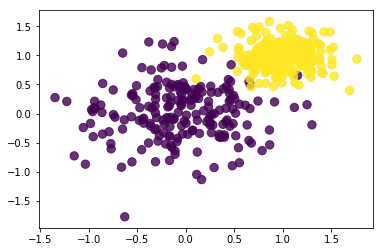

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

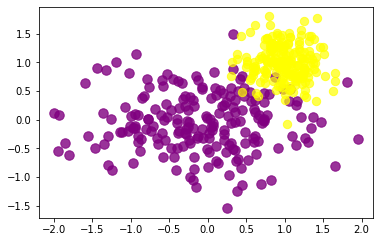

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot2grid((3,1), (0, 0), colspan=2, rowspan=2)

x1 = np.random.normal(0, 0.7, 200)
y1 = np.random.normal(0, 0.5, 200)
x2 = np.random.normal(1, 0.3, 200)
y2 = np.random.normal(1, 0.3, 200)

scatter = ax1.scatter(x=x1, y=y1, s = 90, c = 'purple', alpha = 0.8)
scatter = ax1.scatter(x=x2, y=y2, s = 70, c = 'yellow', alpha = 0.7)

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

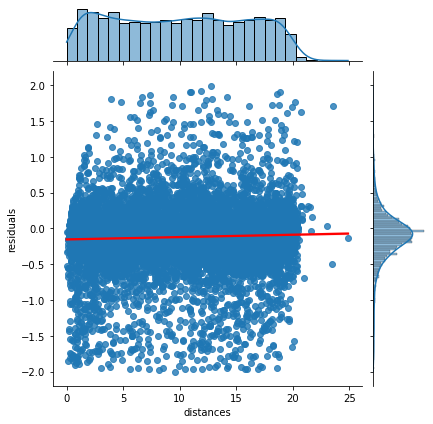

In [29]:
import seaborn as sns
import pandas as pd
import numpy as np

data = np.load('residuals_261.pkl', allow_pickle=True)
df = pd.DataFrame(data.item())

data_frame = df[df['residuals'].abs() < 2]
data_frame

sns.jointplot(x = 'distances', y = 'residuals', data = df_cleaned, kind='reg', line_kws = {'color': 'red'})

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


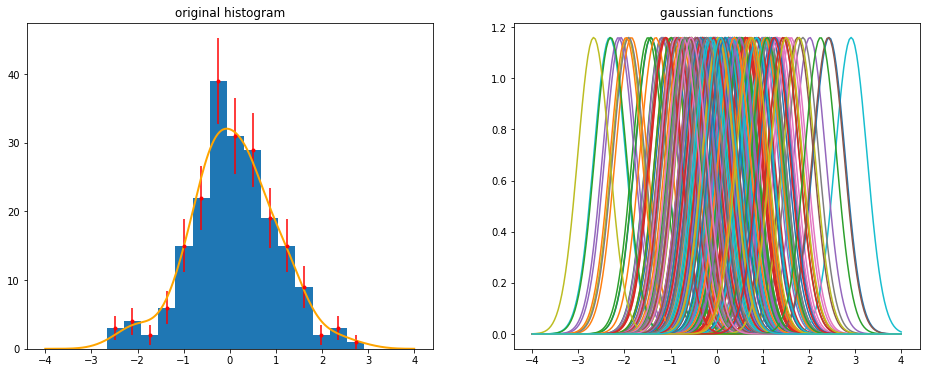

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

N = 200
mean = 0
std = 1
A = np.random.normal(mean,std,N)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
entries, edges, bar = ax1.hist(A, bins = 15)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bars = ax1.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')
ax1.set_title('original histogram')

std1 = 1.06*A.std()*A.size**(-1/5)
x = np.linspace(-4, 4, 200)
gaussians = np.array([stats.norm.pdf(x, loc = A[i], scale = std1) for i in range(len(x))])
for i in range(len(A)):
    ax2.plot(x, gaussians[i])
ax2.set_title('gaussian functions')

sum_gaussians = np.sum(gaussians, axis = 0)
Z = sp.integrate.trapz(sum_gaussians, x)
width = edges[1] - edges[0]
area = width * N
ax1.plot(x, sum_gaussians*area/Z, color ="orange", linewidth = 2)

plt.show()